In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from plotnine import (
    ggplot, aes, geom_bar, geom_errorbar, facet_wrap, scale_fill_manual,
    labs, theme_bw, theme, element_text, element_blank, position_dodge,
    scale_y_continuous
)

# === Input CSVs ===
main_dir = "/gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/classification"
baseline_csv = Path(f"{main_dir}/TS_noCL_300bp_rerun_codeChange_tissue_metrics_logitdelta_binary_20251106-213156.csv")
clade_csv    = Path(f"{main_dir}/TS_CLSwpd_300bp_10Aug_tissue_metrics_logitdelta_binary_20251106-213156.csv")

# === Tissue class annotation ===
tissue_class_csv = Path(
    "/gpfs/commons/home/atalukder/Contrastive_Learning/data/TS_data/tabula_sapiens/final_data/tissue_counts_detailed_ExonBinPsi.csv"
)


In [2]:
# Load both model results
baseline_df = pd.read_csv(baseline_csv)
clade_df    = pd.read_csv(clade_csv)

baseline_df["Model"] = "Baseline"
clade_df["Model"]    = "CLADE"

df = pd.concat([baseline_df, clade_df], ignore_index=True)

# Load tissue classification
tissue_class_df = pd.read_csv(tissue_class_csv)[["Tissue", "SampleClass"]].rename(columns={"Tissue": "tissue"})

# Clean merge keys
df["tissue"] = df["tissue"].astype(str).str.strip()
tissue_class_df["tissue"] = tissue_class_df["tissue"].astype(str).str.strip()

# Merge
merged = df.merge(tissue_class_df, on="tissue", how="inner")
merged["SampleClass"] = (
    merged["SampleClass"]
    .str.replace(" sample", "", case=False)
    .str.strip()
    .str.capitalize()
)

print(f"✅ Merged successfully: {merged.shape[0]} entries")
merged.head()


✅ Merged successfully: 224 entries


,accuracy,precision,recall,f1,auroc,auprc,tissue,model,n,Model,SampleClass
0,0.567982,0.498559,0.440204,0.467568,0.589500,0.533861,HR positive luminal epithelial cell of mammary...,TS_noCL_300bp_rerun_codeChange,912,Baseline,Medium
1,0.516977,0.516977,1.000000,0.681588,0.539039,0.556131,acinar cell of salivary gland,TS_noCL_300bp_rerun_codeChange,913,Baseline,Medium
2,0.567460,0.000000,0.000000,0.000000,0.532824,0.464892,"activated cd4-positive, alpha-beta t cell",TS_noCL_300bp_rerun_codeChange,504,Baseline,Low
3,0.575145,0.598291,0.792453,0.681818,0.555032,0.606058,adventitial fibroblast,TS_noCL_300bp_rerun_codeChange,1384,Baseline,High
4,0.487528,0.481481,0.990476,0.647975,0.537003,0.497947,airway smooth muscle cell,TS_noCL_300bp_rerun_codeChange,441,Baseline,Low


In [ ]:
# import pandas as pd

# # === Step 1: Load tissue counts ===
# tissue_counts = pd.read_csv(tissue_class_csv)[["Tissue", "#1", "#0", "SampleClass"]].rename(columns={"Tissue": "tissue"})

# # Compute random baseline precision (class1 ratio)
# tissue_counts["random_precision"] = tissue_counts["#1"] / (tissue_counts["#1"] + tissue_counts["#0"])

# # Clean up column names for merging
# tissue_counts["tissue"] = tissue_counts["tissue"].astype(str).str.strip()
# tissue_counts["SampleClass"] = (
#     tissue_counts["SampleClass"]
#     .str.replace(" sample", "", case=False)
#     .str.strip()
#     .str.capitalize()
# )

# print("✅ Loaded tissue random baseline info:", tissue_counts.shape)
# print(tissue_counts.head())

# # === Step 2: Merge this random baseline with classification data ===
# merged = merged.merge(tissue_counts[["tissue", "SampleClass", "random_precision"]],
#                       on=["tissue", "SampleClass"],
#                       how="left")

# # === Step 3: Prepare for plotting ===
# metrics = ["precision", "recall", "f1", "auprc", "auroc"]

# # Melt for plot
# melted = merged.melt(
#     id_vars=["SampleClass", "Model", "tissue"],
#     value_vars=metrics,
#     var_name="Metric",
#     value_name="Score"
# )

# # Compute mean ± std
# summary = (
#     melted.groupby(["SampleClass", "Model", "Metric"])["Score"]
#     .agg(["mean", "std"])
#     .reset_index()
# )

# # === Step 4: Add "Random" model ===
# # For AUROC random baseline = 0.5; for others use random_precision
# rand_summary = (
#     tissue_counts.groupby("SampleClass")["random_precision"]
#     .mean()
#     .reset_index()
#     .rename(columns={"random_precision": "mean"})
# )
# rand_summary["std"] = 0.0
# rand_summary["Model"] = "Random"

# # Duplicate per metric
# expanded = []
# for metric in metrics:
#     df = rand_summary.copy()
#     df["Metric"] = metric
#     df["mean"] = 0.5 if metric == "auroc" else df["mean"]
#     expanded.append(df)
# rand_summary = pd.concat(expanded, ignore_index=True)

# # Append random to summary
# summary = pd.concat([summary, rand_summary], ignore_index=True)
# summary["Model"] = pd.Categorical(summary["Model"], ["Baseline", "CLADE", "Random"], ordered=True)


✅ Loaded tissue random baseline info: (112, 5)
               tissue   #1   #0 SampleClass  random_precision
0    nampt neutrophil   21   14         Low          0.600000
1     cd24 neutrophil   69   31         Low          0.690000
2  tuft cell of colon  115   71         Low          0.618280
3           thymocyte  114  102         Low          0.527778
4   mature enterocyte  169  143         Low          0.541667


In [3]:
# Include all five metrics
metrics = ["precision", "recall", "f1", "auprc", "auroc"]

# Long-format for easier grouping
melted = merged.melt(
    id_vars=["SampleClass", "Model", "tissue"],
    value_vars=metrics,
    var_name="Metric",
    value_name="Score"
)

# Compute mean ± std
summary = (
    melted.groupby(["SampleClass", "Model", "Metric"])["Score"]
    .agg(["mean", "std"])
    .reset_index()
)

# Proper categorical order for display
summary["SampleClass"] = pd.Categorical(summary["SampleClass"], ["Low", "Medium", "High"], ordered=True)
summary["Model"] = pd.Categorical(summary["Model"], ["Baseline", "CLADE"], ordered=True)
summary["Metric"] = pd.Categorical(summary["Metric"], ["precision", "recall", "f1", "auprc", "auroc"], ordered=True)


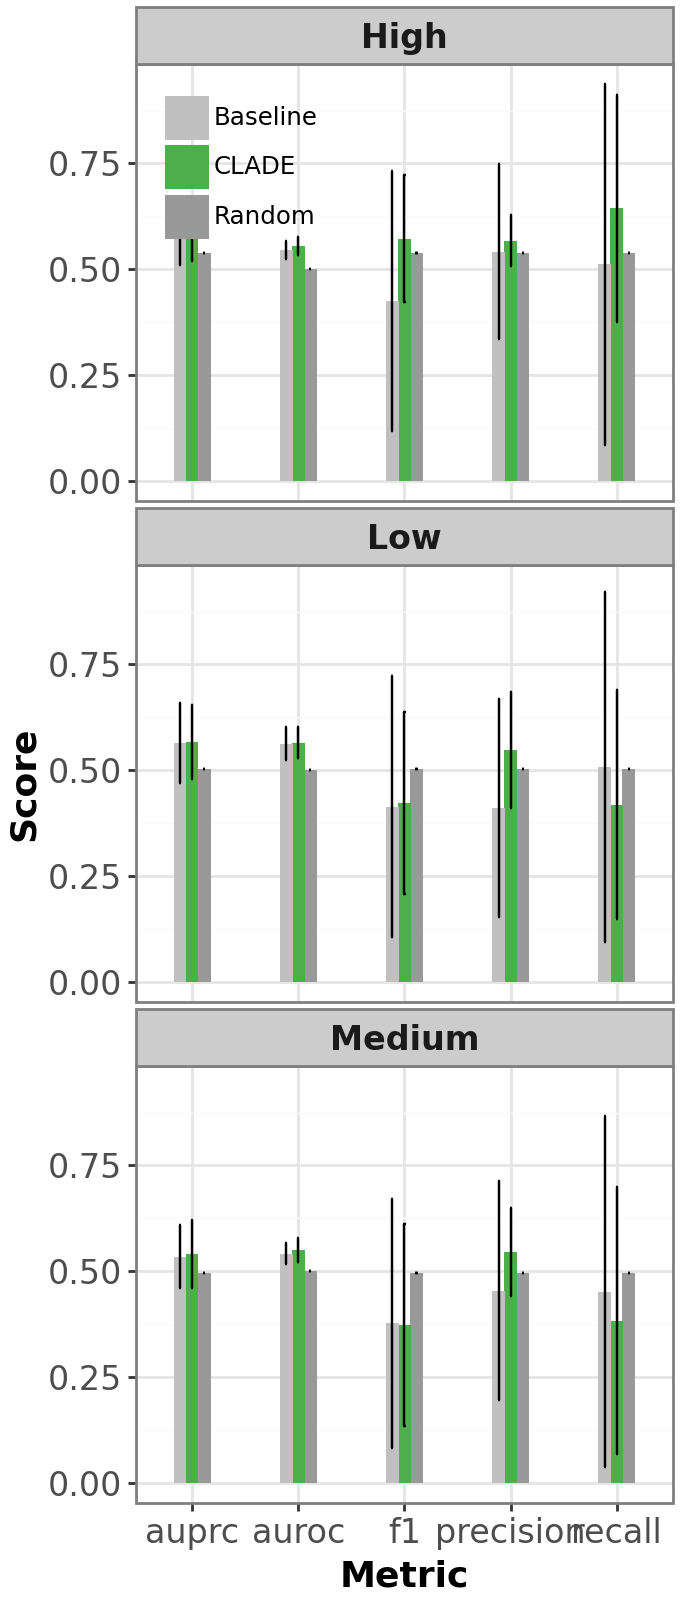

In [ ]:

# # === Step 5: Plot ===
# from plotnine import (
#     ggplot, aes, geom_bar, geom_errorbar, scale_x_discrete,
#     scale_fill_manual, labs, theme_bw, theme,
#     element_text, position_dodge, facet_wrap
# )
# from plotnine.themes.elements import element_blank

# p = (
#     ggplot(summary, aes(x="Metric", y="mean", fill="Model"))
#     + geom_bar(stat="identity", position=position_dodge(width=0.34), width=0.36)
#     + geom_errorbar(
#         aes(ymin=summary["mean"] - summary["std"], ymax=summary["mean"] + summary["std"]),
#         width=0.06, position=position_dodge(width=0.34)
#     )
#     + facet_wrap("~SampleClass", ncol=1, scales="fixed")
#     + scale_fill_manual(values={
#         "Baseline": "#c0c0c0",
#         "CLADE": "#4daf4a",
#         "Random": "#999999"  # darker gray for random
#     })
#     + scale_x_discrete(expand=(0.08, 0.01))
#     + labs(x="Metric", y="Score", fill=None)
#     + theme_bw()
#     + theme(
#         figure_size=(3.4, 8.0),
#         legend_position=(0.05, 0.98),
#         legend_justification=(0, 1),
#         legend_background=element_blank(),
#         legend_title=element_blank(),
#         axis_text_x=element_text(size=12),
#         axis_text_y=element_text(size=12),
#         axis_title_x=element_text(margin={'t': 8}, size=13, weight="bold"),
#         axis_title_y=element_text(size=13, weight="bold"),
#         strip_text=element_text(size=12, weight="bold"),
#         plot_title=element_blank()
#     )
# )

# p.show()


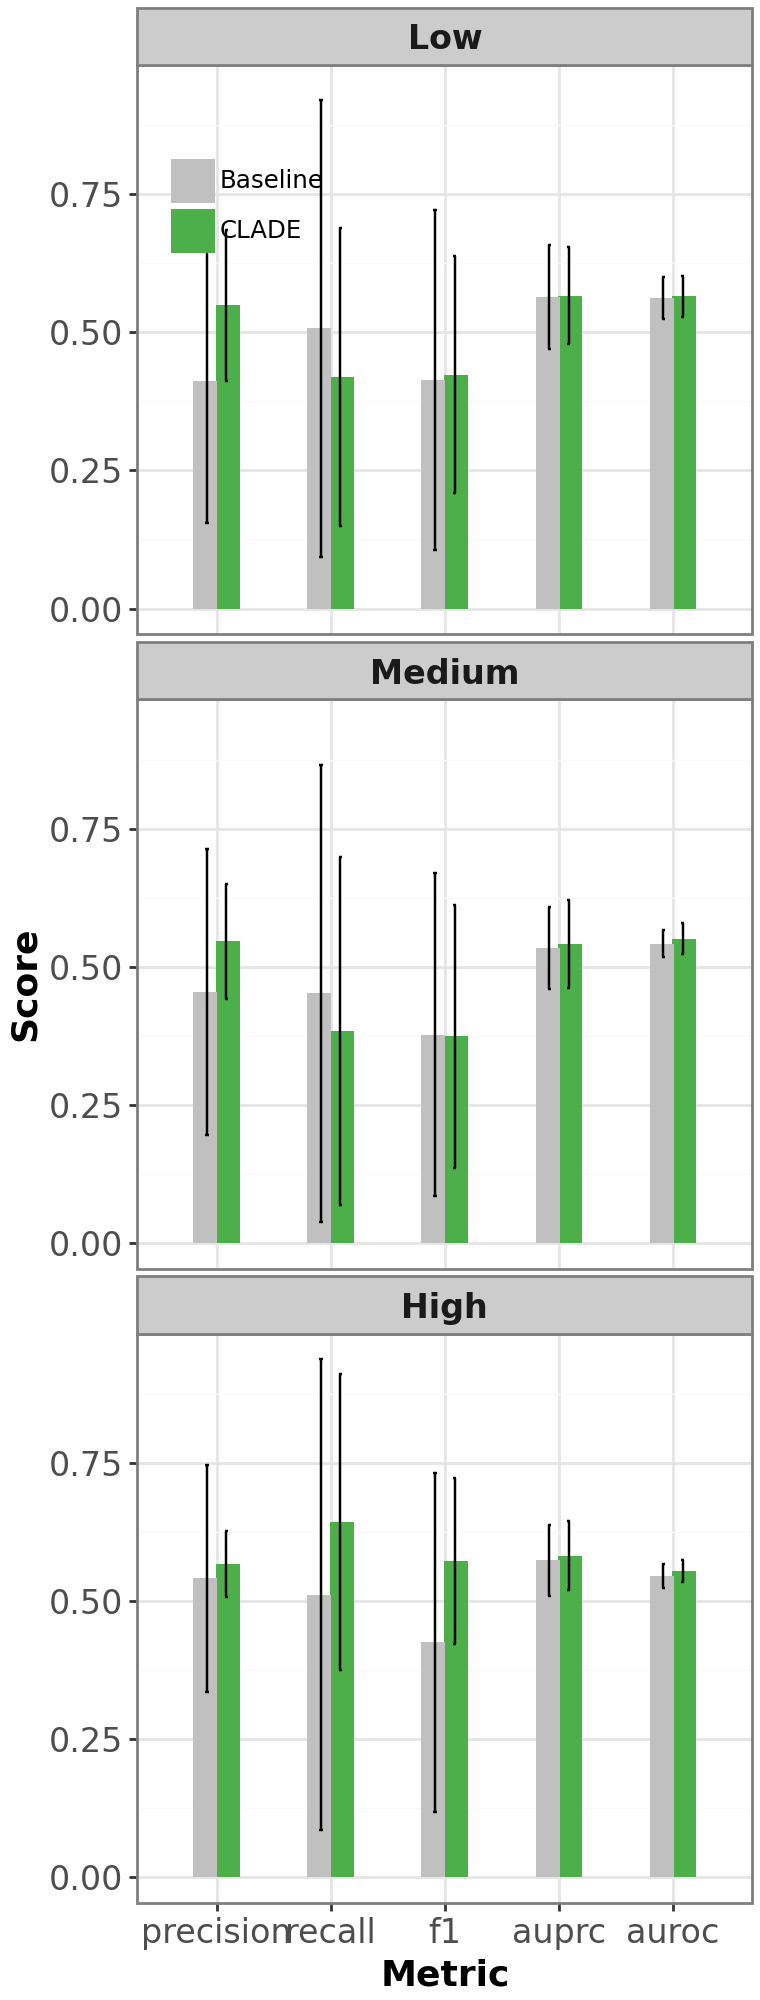

In [30]:
from plotnine import (
    ggplot, aes, geom_bar, geom_errorbar, scale_x_discrete,
    scale_fill_manual, labs, theme_bw, theme,coord_cartesian,
    element_text, position_dodge
)
from plotnine.themes.elements import element_blank

p = (
    ggplot(summary, aes(x="Metric", y="mean", fill="Model"))
    # + geom_bar(stat="identity", position=position_dodge(width=0.34), width=0.36)
    + geom_bar(stat="identity", position=position_dodge(width=0.4), width=0.42)
    + geom_errorbar(
        aes(ymin=summary["mean"] - summary["std"], ymax=summary["mean"] + summary["std"]),
        width=0.06,
        position=position_dodge(width=0.34)
    )
    # Facet with *free scales = False* so bar width looks consistent
    + facet_wrap("~SampleClass", ncol=1, scales="fixed")
    + scale_fill_manual(values={"Baseline": "#c0c0c0", "CLADE": "#4daf4a"})
    # Keep same expansion as “Mean ρ” figure
    + scale_x_discrete(expand=(0.1, 0.05))
    + labs(x="Metric", y="Score", fill=None)
    + theme_bw()
    # + coord_cartesian(ylim=(0.25, 0.85))  # ✅ preferred approach
    + theme(
        # Make the figure slightly wider to match proportions visually
        figure_size=(3.8, 10.0),
        legend_position=(0.05, 0.95),
        legend_justification=(0, 1),
        legend_background=element_blank(),
        legend_title=element_blank(),
        axis_text_x=element_text(size=12),
        axis_text_y=element_text(size=12),
        axis_title_x=element_text(margin={'t': 8}, size=13, weight="bold"),
        axis_title_y=element_text(size=13, weight="bold"),
        strip_text=element_text(size=12, weight="bold"),
        plot_title=element_blank()
    )
)




p.show()


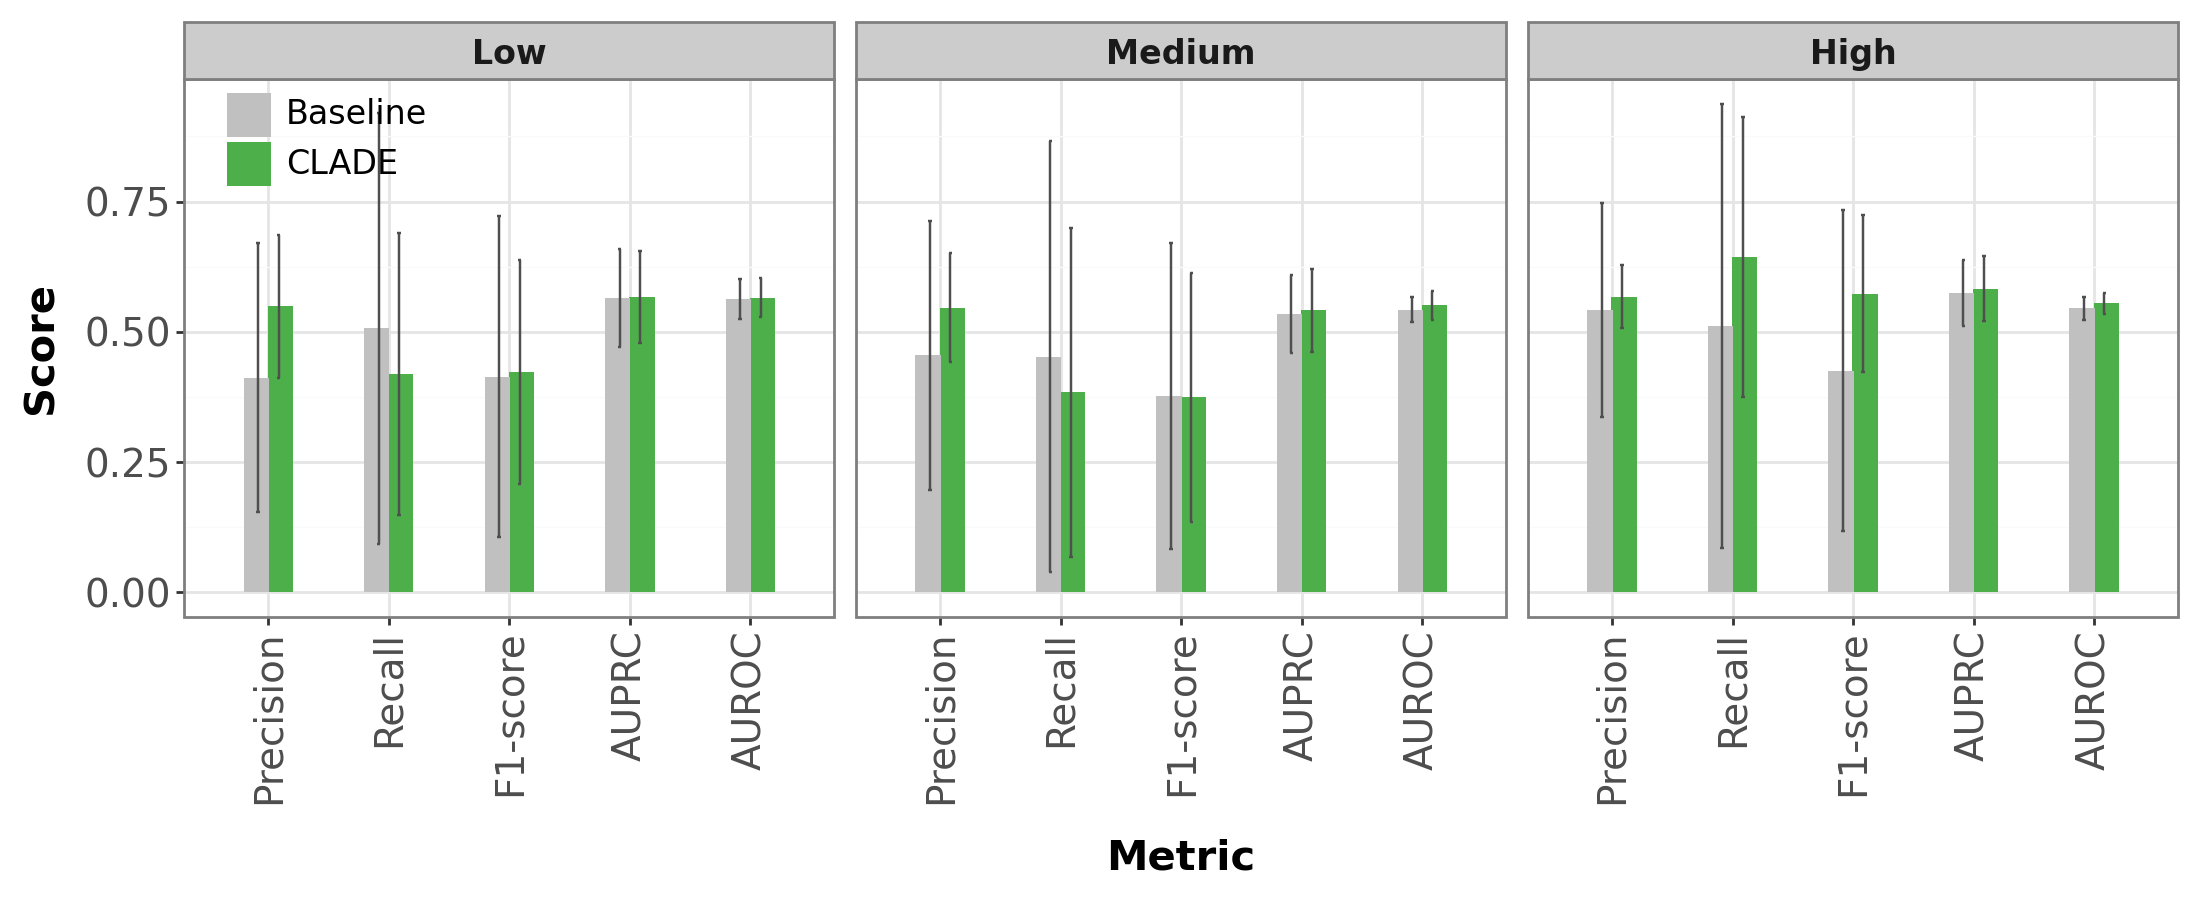

✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TS_tissuClass_SOTA_vs_CLADE_20251108_230826.png
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TS_tissuClass_SOTA_vs_CLADE_20251108_230826.svg
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TS_tissuClass_SOTA_vs_CLADE_20251108_230826.pdf
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TS_tissuClass_SOTA_vs_CLADE_20251108_230826.eps


In [45]:
from plotnine import (
    ggplot, aes, geom_bar, geom_errorbar, scale_x_discrete,
    scale_fill_manual, labs, theme_bw, theme, coord_cartesian,
    element_text, position_dodge
)
from plotnine.themes.elements import element_blank

import time
# --- Relabel Metric names for prettier x-axis ---
metric_labels = {
    "precision": "Precision",
    "recall": "Recall",
    "f1": "F1-score",
    "auprc": "AUPRC",
    "auroc": "AUROC"
}
summary["Metric"] = summary["Metric"].replace(metric_labels)

p = (
    ggplot(summary, aes(x="Metric", y="mean", fill="Model"))
    + geom_bar(stat="identity", position=position_dodge(width=0.4), width=0.42)
    + geom_errorbar(
        aes(ymin=summary["mean"] - summary["std"], ymax=summary["mean"] + summary["std"]),
        width=0.06,
        position=position_dodge(width=0.34),
        color="#4f4f4f"   # ✅ darker gray for std bars
    )
    # ✅ Arrange facets in one row (instead of one column)
    + facet_wrap("~SampleClass", nrow=1, scales="fixed")
    + scale_fill_manual(values={"Baseline": "#c0c0c0", "CLADE": "#4daf4a"})
    + scale_x_discrete(expand=(0.1, 0.05))
    + labs(x="Metric", y="Score", fill=None)
    + theme_bw()
    # Optional: adjust vertical range
    # + coord_cartesian(ylim=(0.25, 0.85))
    + theme(
        figure_size=(11, 4.5),  # ✅ wider figure to fit 3 columns nicely
        legend_position=(0.02, 0.98),        # ✅ top-left inside
        legend_justification=(0, 1),
        legend_background=element_blank(),
        legend_title=element_blank(),
        legend_text=element_text(size=12),   # ✅ make legend text bigger
        axis_text_x=element_text(size=14, angle=90),
        axis_text_y=element_text(size=14),
        axis_title_x=element_text(margin={'t': 5}, size=15, weight="bold"),
        axis_title_y=element_text(size=15, weight="bold"),
        strip_text=element_text(size=12, weight="bold"),
        plot_title=element_blank()
    )
)

p.show()

main_dir = "/gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures"
out_path = f"{main_dir}/fig_TS_tissuClass_SOTA_vs_CLADE_{time.strftime('%Y%m%d_%H%M%S')}"

# --- Draw and save with consistent size ---
fig = p.draw()

# Force the figure to match notebook display ratio
fig.set_size_inches(11, 4.5)  # same as theme figure_size

formats = ['png', 'svg', 'pdf', 'eps']
for fmt in formats:
    save_path = f"{out_path}.{fmt}"
    fig.savefig(
    save_path,
    dpi=300,
    bbox_inches="tight",
    facecolor="white"
    )
    print(f"✅ Saved: {save_path}")



/gpfs/commons/home/atalukder/miniconda3/envs/Myjupyterenv/lib/python3.10/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'fill' is already present.
Adding another scale for 'fill',
which will replace the existing scale.



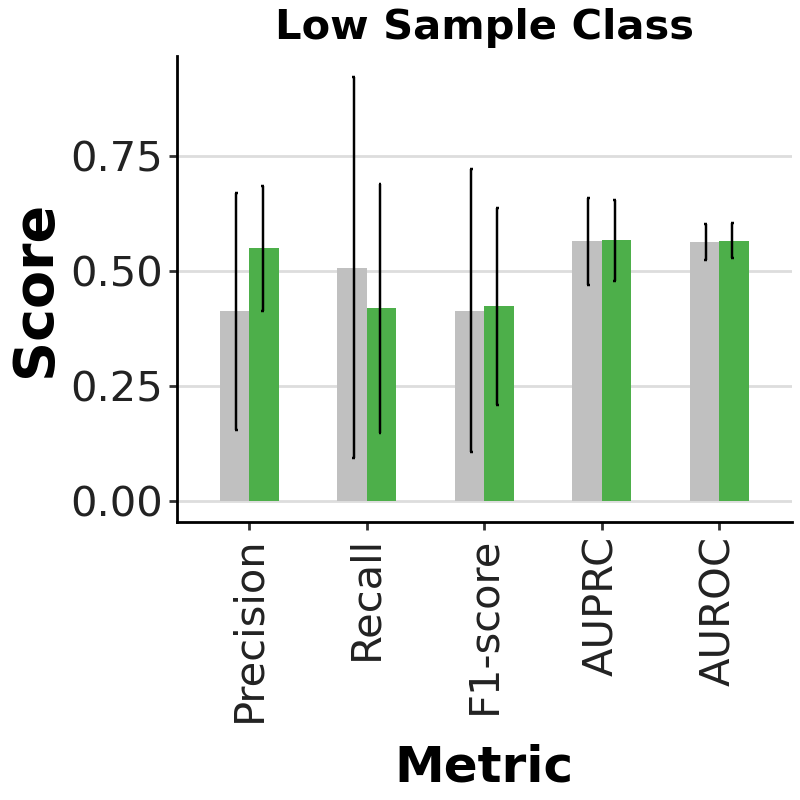

✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_TS_binary_Low_SOTA_vs_CLADE_20251110_030808.png
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_TS_binary_Low_SOTA_vs_CLADE_20251110_030808.svg
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_TS_binary_Low_SOTA_vs_CLADE_20251110_030808.pdf
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_TS_binary_Low_SOTA_vs_CLADE_20251110_030808.eps


/gpfs/commons/home/atalukder/miniconda3/envs/Myjupyterenv/lib/python3.10/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'fill' is already present.
Adding another scale for 'fill',
which will replace the existing scale.



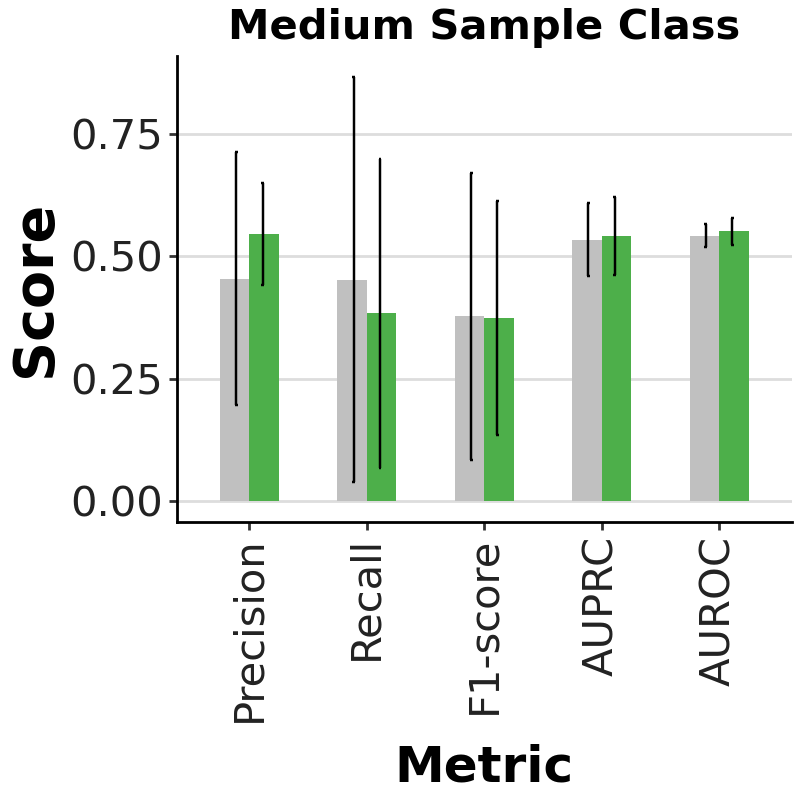

✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_TS_binary_Medium_SOTA_vs_CLADE_20251110_030808.png
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_TS_binary_Medium_SOTA_vs_CLADE_20251110_030808.svg
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_TS_binary_Medium_SOTA_vs_CLADE_20251110_030808.pdf
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_TS_binary_Medium_SOTA_vs_CLADE_20251110_030808.eps


/gpfs/commons/home/atalukder/miniconda3/envs/Myjupyterenv/lib/python3.10/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'fill' is already present.
Adding another scale for 'fill',
which will replace the existing scale.



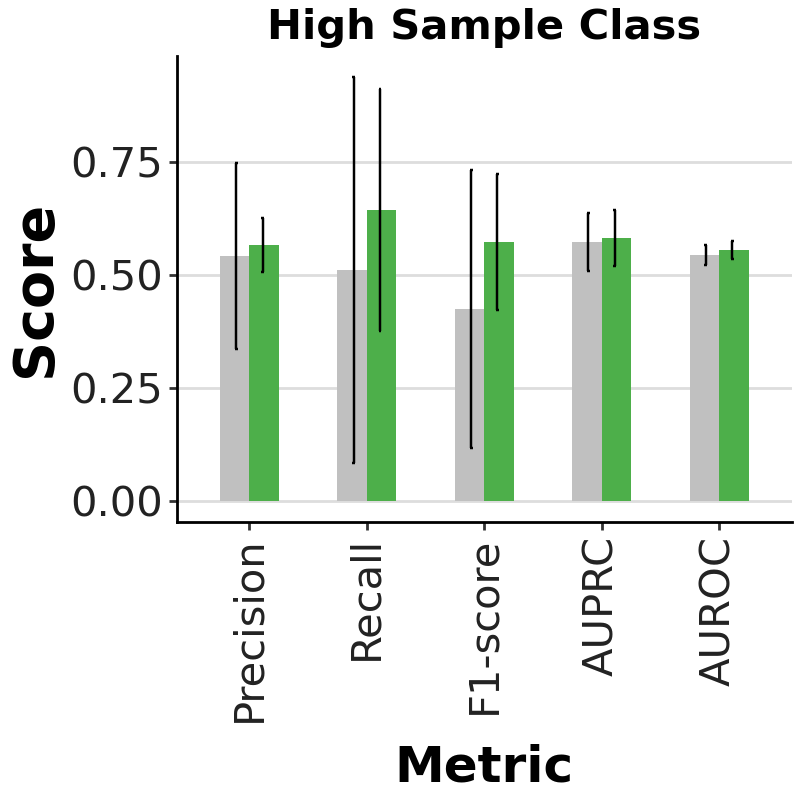

✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_TS_binary_High_SOTA_vs_CLADE_20251110_030808.png
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_TS_binary_High_SOTA_vs_CLADE_20251110_030808.svg
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_TS_binary_High_SOTA_vs_CLADE_20251110_030808.pdf
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_TS_binary_High_SOTA_vs_CLADE_20251110_030808.eps


In [19]:
from plotnine import (
    ggplot, aes, geom_bar, geom_errorbar, scale_x_discrete,
    scale_fill_manual, labs, theme_bw, theme, coord_cartesian,
    element_text, position_dodge
)
from plotnine.themes.elements import element_blank
import time
import matplotlib.pyplot as plt

# --- Relabel Metric names for prettier x-axis ---
metric_labels = {
    "precision": "Precision",
    "recall": "Recall",
    "f1": "F1-score",
    "auprc": "AUPRC",
    "auroc": "AUROC"
}
summary["Metric"] = summary["Metric"].replace(metric_labels)

# --- Set up output directory ---
main_dir = "/gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures"
timestamp = time.strftime('%Y%m%d_%H%M%S')

# --- Loop over classes ---
for cls in ["Low", "Medium", "High"]:
    sub_df = summary[summary["SampleClass"] == cls].copy()

    p = (
        ggplot(sub_df, aes(x="Metric", y="mean", fill="Model"))
         + geom_bar(stat="identity", position=position_dodge(width=0.5), width=0.5)
        + geom_errorbar(
            aes(ymin=sub_df["mean"] - sub_df["std"], ymax=sub_df["mean"] + sub_df["std"]),width=0.05, position=position_dodge(width=0.45)
            # width=0.06,
            # position=position_dodge(width=0.34),
            # #  color="#4f4f4f",   # ✅ dark gray error bars
            # size=0.7
        )
        + scale_fill_manual(values={"Baseline": "#c0c0c0", "CLADE": "#4daf4a"})
    + scale_fill_manual(values={"Baseline": "#c0c0c0", "CLADE": "#4daf4a"})
    + scale_x_discrete(expand=(0.08, 0.01))
        + labs(x="Metric", y="Score", fill=None)
        + theme_bw()
        # + theme(
        #     figure_size=(4, 4.5),
        #     legend_position=(0.05, 0.97),        # ✅ top-left inside
        #     legend_justification=(0, 1),
        #     legend_background=element_blank(),
        #     legend_title=element_blank(),
        #     legend_text=element_text(size=12),
        #     axis_text_x=element_text(size=14, angle=90),
        #     axis_text_y=element_text(size=14),
        #     axis_title_x=element_text(margin={'t': 5}, size=15, weight="bold"),
        #     axis_title_y=element_text(size=15, weight="bold"),
        #     strip_text=element_text(size=12, weight="bold"),
        #     plot_title=element_text(size=14, weight="bold", ha="center")
        # )
        + theme(
        figure_size=(4, 4),
             legend_position='none',       # top-right corner
            legend_justification=(1, 1),
                legend_background=element_blank(),
                legend_title=element_blank(),
                legend_text=element_text(size=15),
        axis_text_x=element_text(size=15, ha="center", va="top", color="#222222", angle=90),
        axis_text_y=element_text(size=15, color="#222222"),
        axis_title_x=element_text(margin={'t': 8}, size=18, weight="bold"),
        axis_title_y=element_text(size=20, weight="bold"),
        plot_title=element_text(size=15, weight="bold", ha="center"),
        panel_border=element_blank(),
        panel_grid_major_y=element_text(color="#dddddd"),
        panel_grid_minor_y=element_blank(),
        panel_grid_major_x=element_blank(),
        panel_grid_minor_x=element_blank(),
        axis_line_x=element_text(color="black"),
        axis_line_y=element_text(color="black"),
    )
        
    )

    # --- Add title (optional) ---
    p += labs(title=f"{cls} Sample Class")

    # --- Display in notebook ---
    p.show()

    # --- Save each class figure separately ---
    out_path = f"{main_dir}/fig_TissueWise_TS_binary_{cls}_SOTA_vs_CLADE_{timestamp}"

    fig = p.draw()
    fig.set_size_inches(4, 4.5)

    for fmt in ["png", "svg", "pdf", "eps"]:
        save_path = f"{out_path}.{fmt}"
        fig.savefig(
            save_path,
            dpi=300,
            bbox_inches="tight",
            facecolor="white"
        )
        print(f"✅ Saved: {save_path}")

    plt.close(fig)
